In [1]:
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications.vgg19 import decode_predictions, preprocess_input

model = VGG19(weights='imagenet')


2022-03-13 13:32:30.274896: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-13 13:32:30.281357: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-13 13:32:30.281534: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-03-13 13:32:30.282256: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

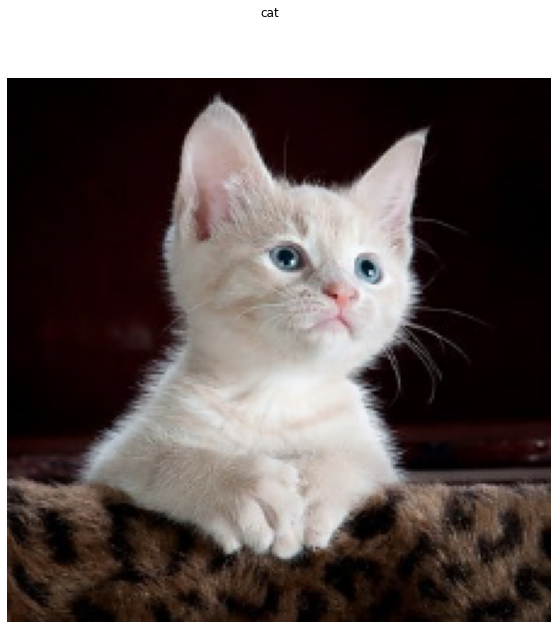

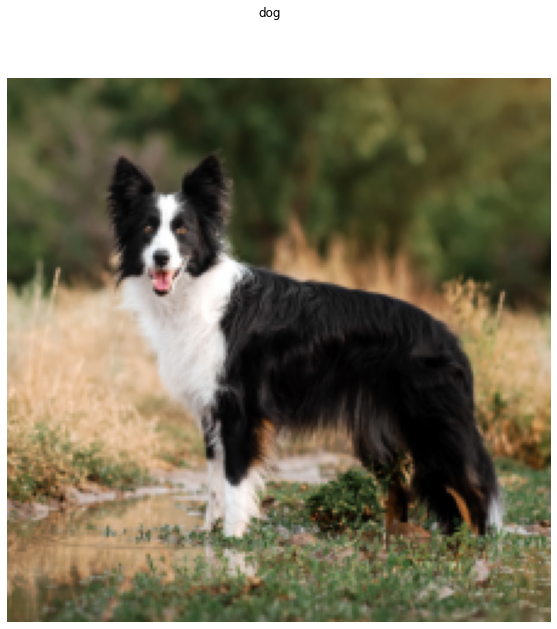

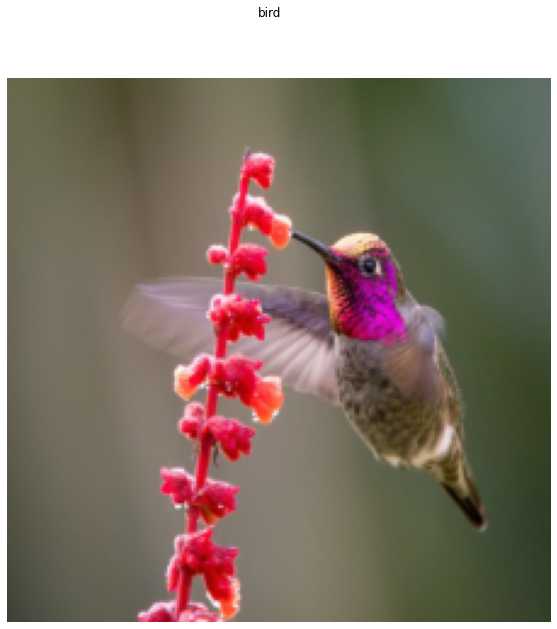

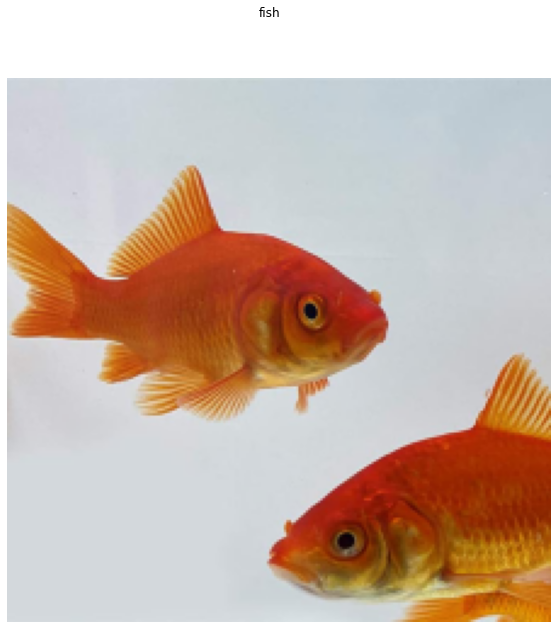

In [2]:
import requests
import matplotlib.pyplot as plt
import numpy as np

from skimage.io import imread
from skimage.transform import resize


urls = {
    'cat': 'https://cdn.pixabay.com/photo/2014/11/30/14/11/cat-551554__340.jpg',
    'dog': ('https://static.wikia.nocookie.net/naturerules1/images/f/f9/Border-collie-1.jpg/'
            'revision/latest?cb=20210403210149'),
    'bird': 'https://static.independent.co.uk/2021/04/29/22/newFile-3.jpg?quality=75&width=1200&auto=webp',
    'fish': 'https://m.media-amazon.com/images/I/61QN8NWuNlL._AC_SX679_.jpg'
}

images = {}

for key in urls:
    req = requests.get(urls[key])

    with open(f'/tmp/{key}.jpg', 'wb') as f:
        f.write(req.content)

    fig = plt.figure(figsize=(10, 10))
    fig.suptitle(key)
    img = imread(f'/tmp/{key}.jpg')
    img = resize(img, (224, 224), preserve_range=True)
    img = img.astype(np.uint8)
    plt.imshow(img)
    plt.gca().axis('off')
    plt.show()
    
    img = preprocess_input(img)
    images[key] = img

In [3]:
for key in images:
    prediction = model.predict(np.expand_dims(images[key], axis=0))
    print(f'Actual class: {key}')
    print('Predictions:')
    print(decode_predictions(prediction, 10))

2022-03-13 13:32:35.428377: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-03-13 13:32:35.850511: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8100
2022-03-13 13:32:36.068865: W tensorflow/stream_executor/gpu/asm_compiler.cc:113] *** WARNING *** You are using ptxas 9.1.108, which is older than 9.2.88. ptxas 9.x before 9.2.88 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You do not need to update to CUDA 9.2.88; cherry-picking the ptxas binary is sufficient.


Actual class: cat
Predictions:
[[('n02124075', 'Egyptian_cat', 0.5702428), ('n02123045', 'tabby', 0.22358966), ('n02123159', 'tiger_cat', 0.08013459), ('n02127052', 'lynx', 0.030481633), ('n03085013', 'computer_keyboard', 0.02249998), ('n03793489', 'mouse', 0.008207956), ('n02123597', 'Siamese_cat', 0.008201845), ('n03642806', 'laptop', 0.005193917), ('n02123394', 'Persian_cat', 0.004617361), ('n04074963', 'remote_control', 0.00424049)]]
Actual class: dog
Predictions:
[[('n02106166', 'Border_collie', 0.86433685), ('n02106030', 'collie', 0.11977325), ('n02086910', 'papillon', 0.008389887), ('n02105855', 'Shetland_sheepdog', 0.0057414775), ('n02105056', 'groenendael', 0.00054181356), ('n02107683', 'Bernese_mountain_dog', 0.00030215768), ('n02113186', 'Cardigan', 0.0002027266), ('n02085782', 'Japanese_spaniel', 0.00014763027), ('n02090622', 'borzoi', 0.00011002268), ('n02102040', 'English_springer', 7.221178e-05)]]
Actual class: bird
Predictions:
[[('n01833805', 'hummingbird', 0.9999993),

In [7]:
from explainability import LayerwiseRelevancePropagator

idx = [
    ('fish', 1),
    ('dog', 232),
    ('cat', 281),
    ('bird', 94)
]

explainers = {
    p[0]: LayerwiseRelevancePropagator(model, layer=26, idx=p[1], epsilon=1, alpha=2, beta=1) \
    for p in idx
}

In [8]:
explanations = np.zeros((4, 4), dtype=object)

keys = [p[0] for p in idx]

for i in range(len(keys)):
    for j in range(len(keys)):
        explanations[i][j] = explainers[keys[i]](np.expand_dims(images[keys[j]], axis=0))

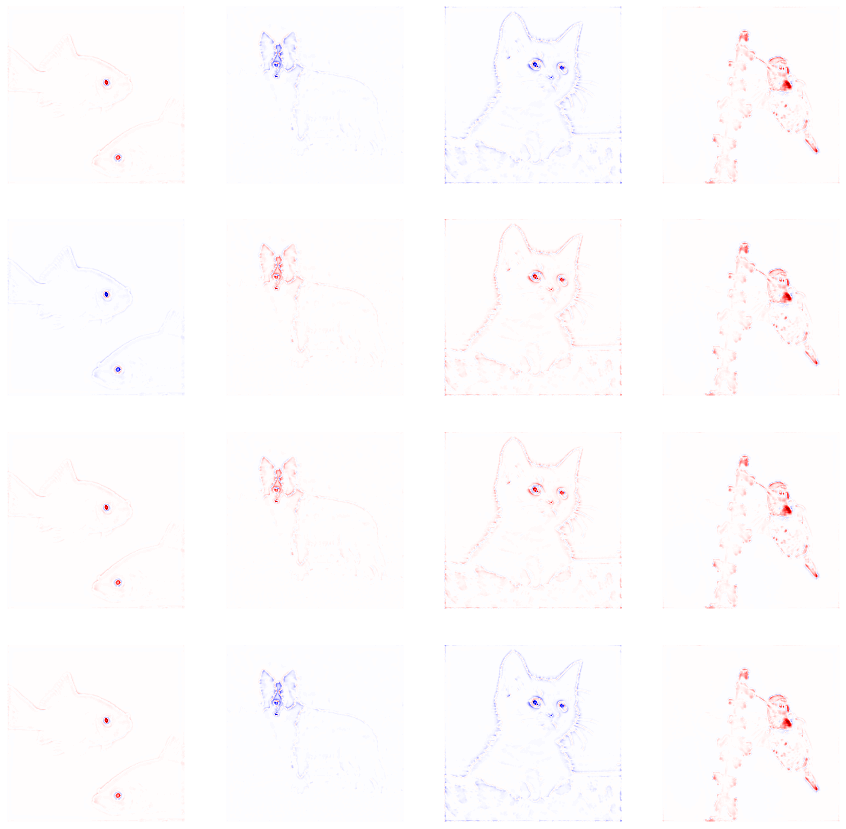

In [9]:
fig, ax = plt.subplots(4, 4, figsize=(15, 15))

for i in range(len(explanations)):
    for j in range(len(explanations[i])):
        explanation = np.sum(explanations[i][j][0], axis=-1)
        explanation = explanation / np.amax(np.abs(explanation))
        ax[i][j].imshow(explanation, cmap='seismic', clim=(-1, 1))
        ax[i][j].axis('off')
        
plt.show()